# Análisis Exploratorio de Datos - Mercado Inmobiliario

Este cuaderno realiza la limpieza y análisis exploratorio de los datos scrapeados de ZonaProp.

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import ast
from sklearn.linear_model import LinearRegression

# Configuración de estilo
sns.set_theme(style="whitegrid")
pd.set_option('display.max_columns', None)

## 1. Carga de Datos
En esta sección cargaremos los datos desde el archivo CSV.

In [3]:
# Leemos el dataset
try:
    df = pd.read_csv("../data/raw/real_estate_listings.csv")
    print(f"Dimensiones iniciales: {df.shape}")
    display(df.head())
except FileNotFoundError:
    print("Archivo no encontrado. Verifica la ruta.")

Dimensiones iniciales: (60, 8)


,price,location,features,expensas,disposition,seniority,description,url
0,USD 76.000,"Floresta, Capital Federal","['44 m² tot.', '1 amb.', '1 baño']",NaN,Frente,NaN,Departamento de 1 ambiente a estrenar - Pronta...,https://www.zonaprop.com.ar/propiedades/clasif...
1,Consultar precio,"Balvanera, Capital Federal","['80 m² tot.', '3 amb.', '2 dorm.', '2 baños']",NaN,NaN,NaN,- Unidad de tres ambientes con dos baños compl...,https://www.zonaprop.com.ar/propiedades/clasif...
2,USD 300.000,"Recoleta, Capital Federal","['130 m² tot.', '4 amb.', '3 dorm.', '3 baños'...",$ 520.000 Expensas,Frente,NaN,Paraná y Arenales – A metros de Plaza Vicente ...,https://www.zonaprop.com.ar/propiedades/clasif...
3,USD 150.000,"Villa Pueyrredón, Capital Federal","['2 un.', '3 amb.', '58 a 68 m² tot.', 'Parril...",NaN,Frente,NaN,Excelentes semipisos de 3 y 4 ambientes con co...,https://www.zonaprop.com.ar/propiedades/empren...
4,USD 135.000,"Palermo, Capital Federal","['54 m² tot.', '2 amb.', '1 dorm.', '1 baño']",NaN,Frente,NaN,_ Departamento de un dormitorio en venta ubica...,https://www.zonaprop.com.ar/propiedades/clasif...


## 2. Limpieza y Procesamiento de Datos
En esta sección limpiaremos y procesaremos los datos para poder utilizarlos de forma apropiada.

In [4]:
# 1. Limpieza de strings
df['features_clean'] = df['features'].str.replace(r"[[\]']", "", regex=True)
# Aseguramos que la descripcion sea string para evitar errores con nulos
df['description'] = df['description'].fillna('')

# 2. Función de extracción general
def extract_opt(text, pattern):
    match = re.search(fr'(\d+)\s*(?:{pattern})', text, re.IGNORECASE)
    return int(match.group(1)) if match else 0

# 3. Extracción de features 
df['m2'] = df['features_clean'].apply(lambda x: extract_opt(x, 'm²|metros'))
df['ambientes'] = df['features_clean'].apply(lambda x: extract_opt(x, 'amb'))
df['baños'] = df['features_clean'].apply(lambda x: extract_opt(x, 'baños'))
df['dormitorios'] = df['features_clean'].apply(lambda x: extract_opt(x, 'dorm'))
df['cocheras'] = df['features_clean'].apply(lambda x: extract_opt(x, 'coch'))

# 4. Limpieza de precio 
df['precio_usd'] = pd.to_numeric(df['price'].str.replace(r'[^0-9]', '', regex=True), errors='coerce')

# 5. Filtrado y Limpieza Final
df_clean = df.dropna(subset=['precio_usd']).copy()
df_clean['ubicación'] = df_clean['location']

df_clean['baños'] = df_clean['baños'].replace(0,1)

cols_finales = ['precio_usd', 'ubicación', 'm2', 'ambientes', 'dormitorios', 'baños', 'cocheras']
df_clean = df_clean[cols_finales].fillna(0)

df_clean.head()

c:\Users\guard\AppData\Local\Programs\Python\Python314\Lib\site-packages\pandas\core\strings\object_array.py:205: FutureWarning: Possible nested set at position 1
  pat = re.compile(pat, flags=flags)


,precio_usd,ubicación,m2,ambientes,dormitorios,baños,cocheras
0,76000.0,"Floresta, Capital Federal",44,1,0,1,0
2,300000.0,"Recoleta, Capital Federal",130,4,3,3,1
3,150000.0,"Villa Pueyrredón, Capital Federal",68,3,0,1,0
4,135000.0,"Palermo, Capital Federal",54,2,1,1,0
5,76000.0,"Centro / Microcentro, Capital Federal",57,2,1,1,0


## 3. Análisis Exploratorio de Datos (EDA)
En esta sección generaremos nuevas variables y realizaremos un análisis exhaustivo de los datos inmobiliarios.

In [5]:
# 1. Feature Engineering: Creación de nuevas variables

# Precio por m2 (Dólares / m2)
# Filtramos propiedades con m2 > 0 para evitar divisiones por cero
df_clean = df_clean[df_clean['m2'] > 0].copy()
df_clean['precio_m2'] = df_clean['precio_usd'] / df_clean['m2']

# Relación cantidad de ambientes por m2
df_clean['ambientes_m2'] = df_clean['ambientes'] / df_clean['m2']

# Extracción del nombre del Barrio desde la columna 'ubicación'
df_clean['barrio'] = df_clean['ubicación'].apply(lambda x: x.split(',')[0].strip() if isinstance(x, str) else 'Desconocido')

print(f"Cantidad de barrios identificados: {df_clean['barrio'].nunique()}")
print("Variables creadas: precio_m2, ambientes_m2, barrio")
display(df_clean[['ubicación', 'barrio', 'precio_usd', 'm2', 'precio_m2']].head())

Cantidad de barrios identificados: 30
Variables creadas: precio_m2, ambientes_m2, barrio


,ubicación,barrio,precio_usd,m2,precio_m2
0,"Floresta, Capital Federal",Floresta,76000.0,44,1727.272727
2,"Recoleta, Capital Federal",Recoleta,300000.0,130,2307.692308
3,"Villa Pueyrredón, Capital Federal",Villa Pueyrredón,150000.0,68,2205.882353
4,"Palermo, Capital Federal",Palermo,135000.0,54,2500.000000
5,"Centro / Microcentro, Capital Federal",Centro / Microcentro,76000.0,57,1333.333333


### 3.1 Identificación de Valores Atípicos (Outliers)
Visualizamos la distribución de las variables clave para detectar valores extremos que puedan sesgar el análisis.

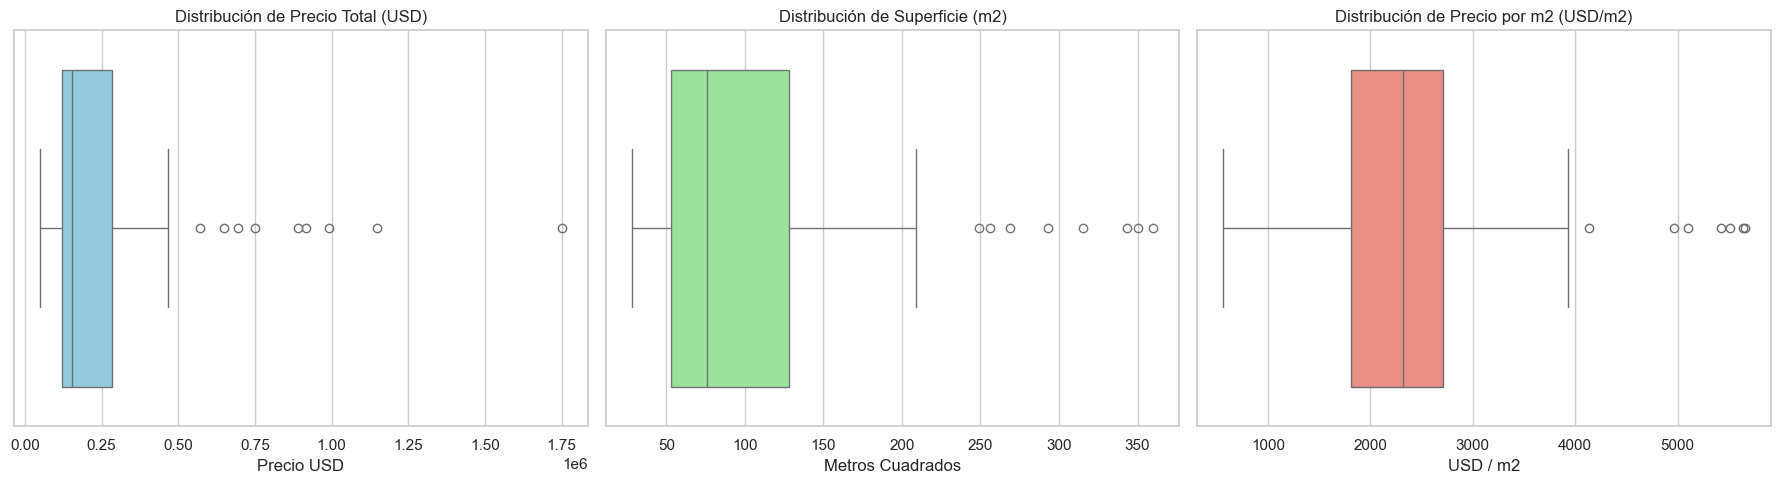

In [6]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Boxplot Precio Total
sns.boxplot(x=df_clean['precio_usd'], ax=axes[0], color='skyblue')
axes[0].set_title('Distribución de Precio Total (USD)')
axes[0].set_xlabel('Precio USD')

# Boxplot Superficie
sns.boxplot(x=df_clean['m2'], ax=axes[1], color='lightgreen')
axes[1].set_title('Distribución de Superficie (m2)')
axes[1].set_xlabel('Metros Cuadrados')

# Boxplot Precio m2
sns.boxplot(x=df_clean['precio_m2'], ax=axes[2], color='salmon')
axes[2].set_title('Distribución de Precio por m2 (USD/m2)')
axes[2].set_xlabel('USD / m2')

plt.tight_layout()
plt.show()


### 3.2 Segmentación Geográfica
Analizamos el precio promedio y el valor del m² agrupados por barrio. Esto permite identificar zonas premium y oportunidades de inversión.

Top 10 Barrios más caros por m2:


,precio_usd,precio_m2,cantidad
barrio,,,
Palermo Chico,1.160000e+06,5265.306122,2
Núñez,6.070000e+05,3399.509804,2
Belgrano,5.340492e+05,3300.413513,8
Palermo,3.283600e+05,3257.290278,5
Monserrat,1.230000e+05,3236.842105,1
Las Cañitas,3.050000e+05,3216.666667,2
Recoleta,3.388333e+05,2698.336017,6
Barracas,1.299000e+05,2651.020408,1
Palermo Nuevo,1.330000e+05,2509.433962,1


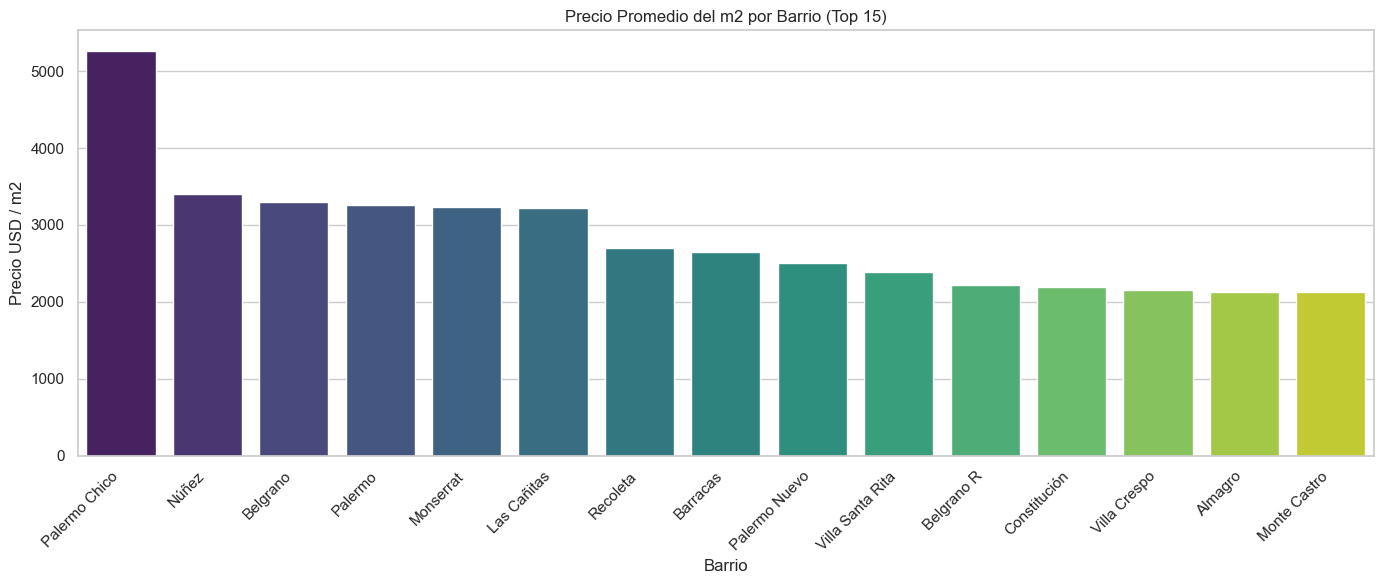

In [7]:
# Agrupamos por barrio y calculamos medias
barrio_stats = df_clean.groupby('barrio').agg({
    'precio_usd': 'mean',
    'precio_m2': 'mean',
    'ubicación': 'count'  # Cantidad de propiedades
}).rename(columns={'ubicación': 'cantidad'}).sort_values('precio_m2', ascending=False)

# Filtramos solo barrios con una cantidad mínima representativa de datos
barrio_stats = barrio_stats[barrio_stats['cantidad'] > 0]

print("Top 10 Barrios más caros por m2:")
display(barrio_stats.head(10))

# Visualización de los Top 15 Barrios por Precio m2
plt.figure(figsize=(14, 6))
top_barrios = barrio_stats.head(15)
sns.barplot(x=top_barrios.index, y=top_barrios['precio_m2'], hue=top_barrios.index, palette='viridis', legend=False)
plt.xticks(rotation=45, ha='right')
plt.title('Precio Promedio del m2 por Barrio (Top 15)')
plt.ylabel('Precio USD / m2')
plt.xlabel('Barrio')
plt.tight_layout()
plt.show()

### 3.3 Drivers de Valor: Impacto de Cocheras y Baños
Evaluamos cómo la presencia de cochera y la cantidad de baños influyen en el precio de la propiedad.

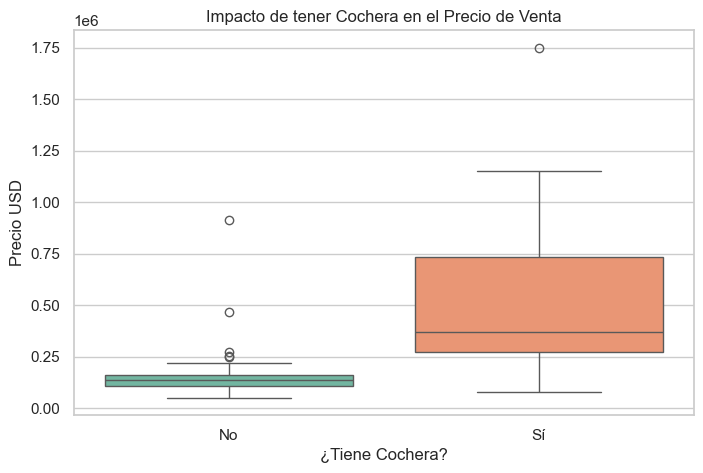

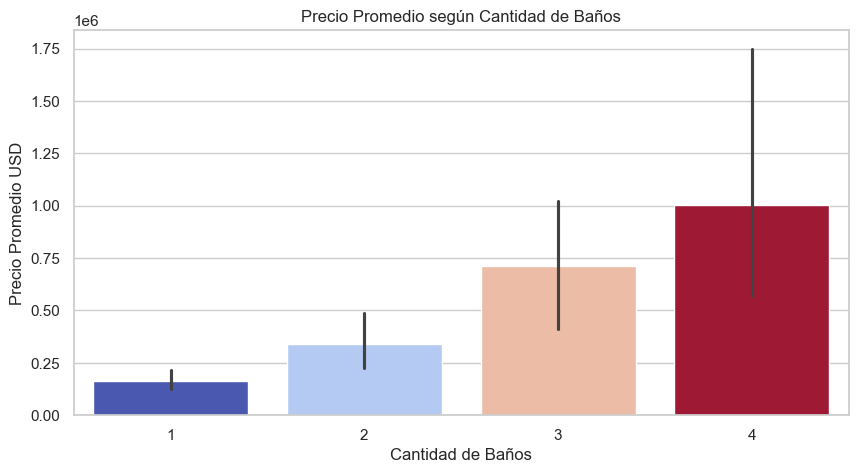

In [8]:
# Crear variable categórica para 'Tiene Cochera'
df_clean['tiene_cochera'] = df_clean['cocheras'].apply(lambda x: 'Sí' if x > 0 else 'No')

# Visualización: Precio vs Cochera
plt.figure(figsize=(8, 5))
sns.boxplot(x='tiene_cochera', y='precio_usd', data=df_clean, palette='Set2', hue='tiene_cochera')
plt.title('Impacto de tener Cochera en el Precio de Venta')
plt.ylabel('Precio USD')
plt.xlabel('¿Tiene Cochera?')
plt.show()

# Visualización: Precio vs Cantidad de Baños
# Como ya hemos imputado siempre >= 1 baño, no deberíamos tener 0s.
plt.figure(figsize=(10, 5))
sns.barplot(x='baños', y='precio_usd', data=df_clean, palette='coolwarm', hue='baños', legend=False)
plt.title('Precio Promedio según Cantidad de Baños')
plt.ylabel('Precio Promedio USD')
plt.xlabel('Cantidad de Baños')
plt.show()

### 3.4 Matriz de Correlación
Analizamos la relación lineal entre las variables numéricas.

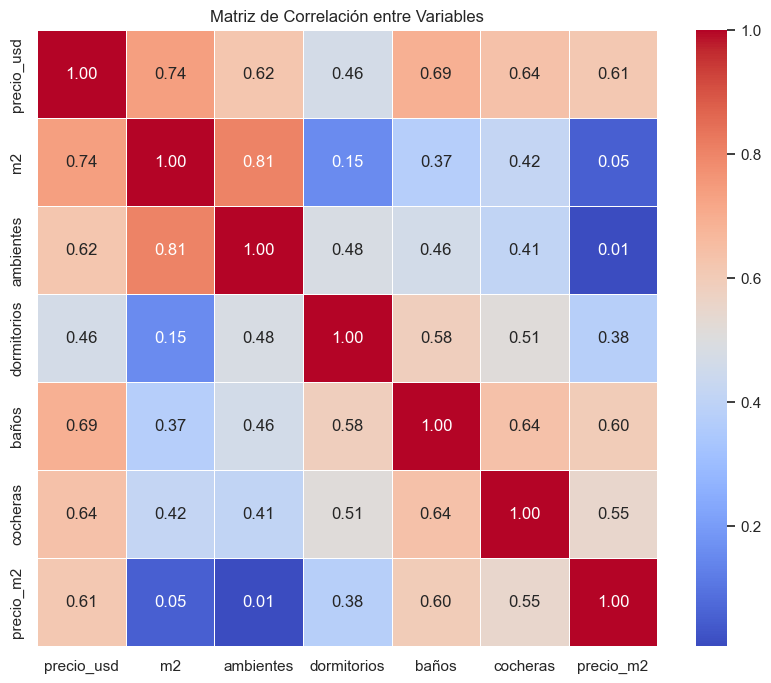

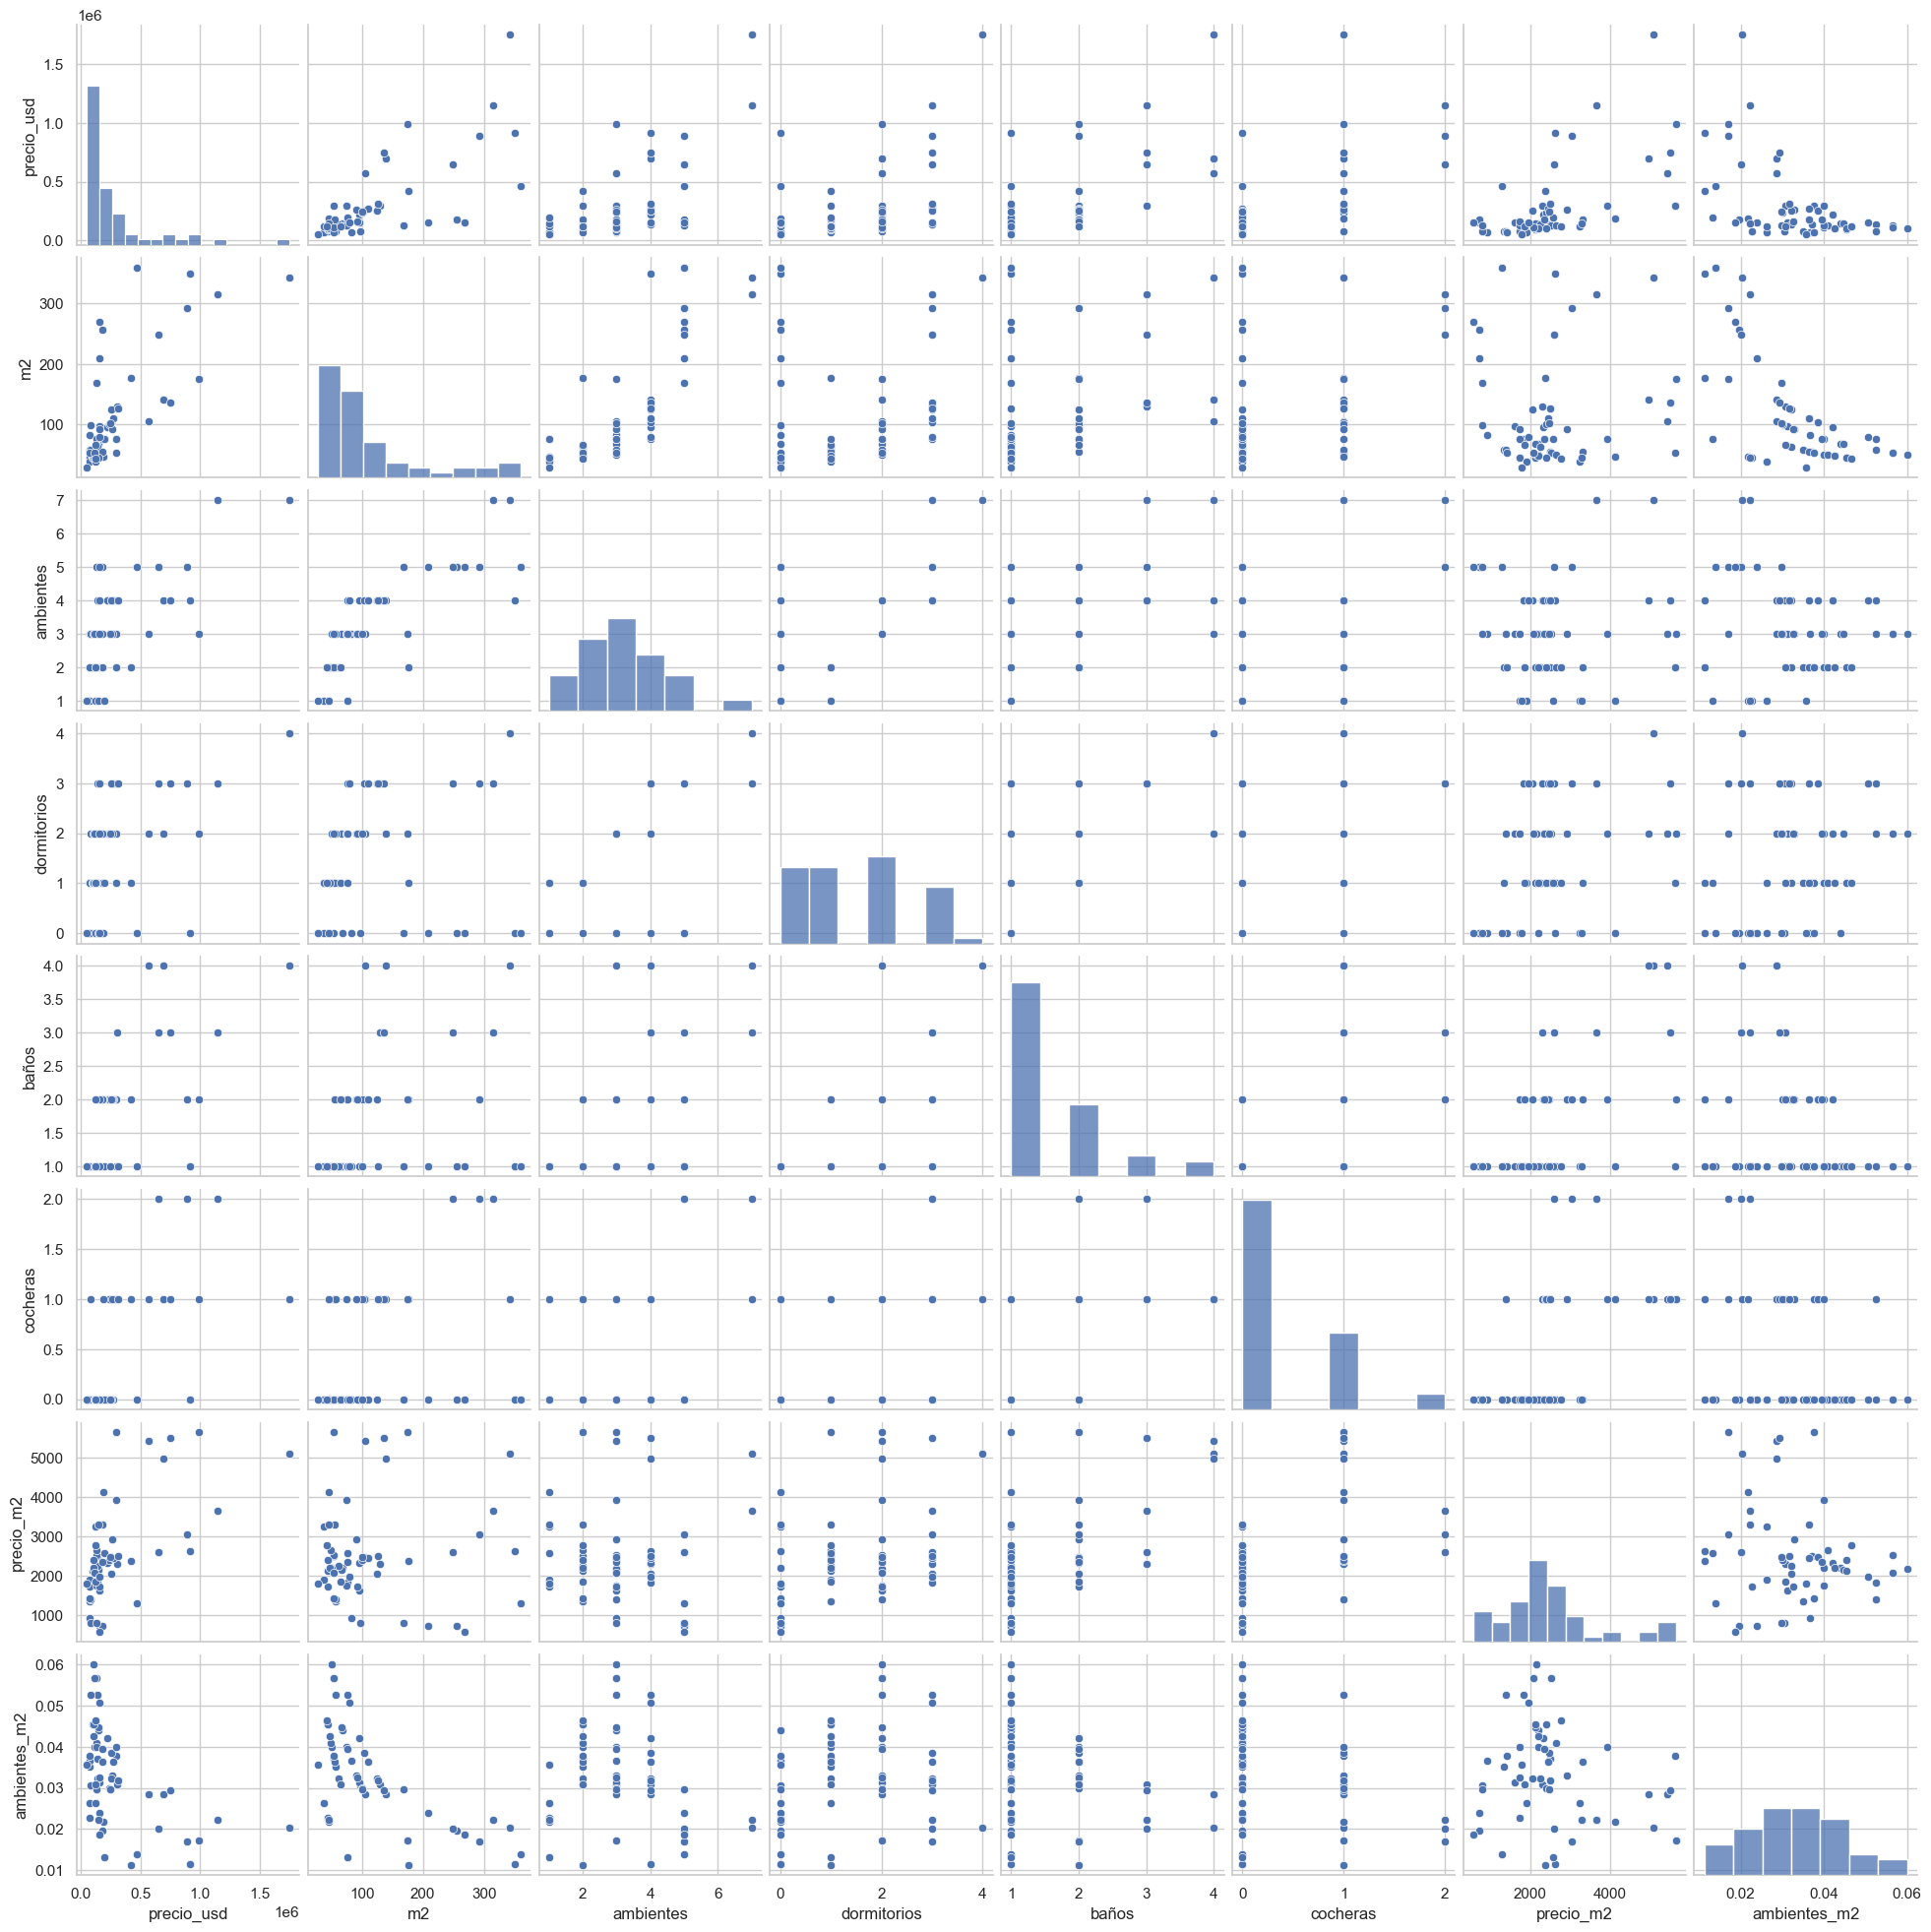

In [9]:
# Seleccionamos variables numéricas relevantes
vars_corr = ['precio_usd', 'm2', 'ambientes', 'dormitorios', 'baños', 'cocheras', 'precio_m2']
corr_matrix = df_clean[vars_corr].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title('Matriz de Correlación entre Variables')
plt.show()

# Relaciones entre variables numéricas
sns.pairplot(df_clean)

## 4. Regresión Lineal 
En esta sección generaremos una regresión lineal para predecir el precio de una propiedad.

## 4. Regresion Lineal
Predicción del precio de propiedades utilizando regresión lineal.

Datos de entrenamiento: (47, 5)
Datos de prueba: (12, 5)

--- Resultados del Modelo ---
R² Score: 0.7314
MAE: USD 114,690.63
RMSE: USD 157,076.52

--- Coeficientes ---
m2: 2,789.17
ambientes: -69,175.50
baños: 162,051.46
dormitorios: 75,349.66
cocheras: -6,513.27
Intercepto: -170,553.85


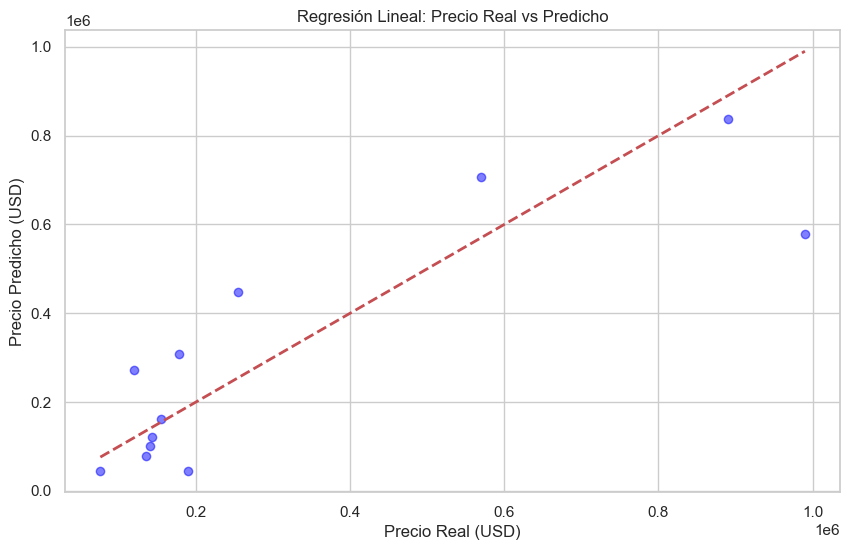

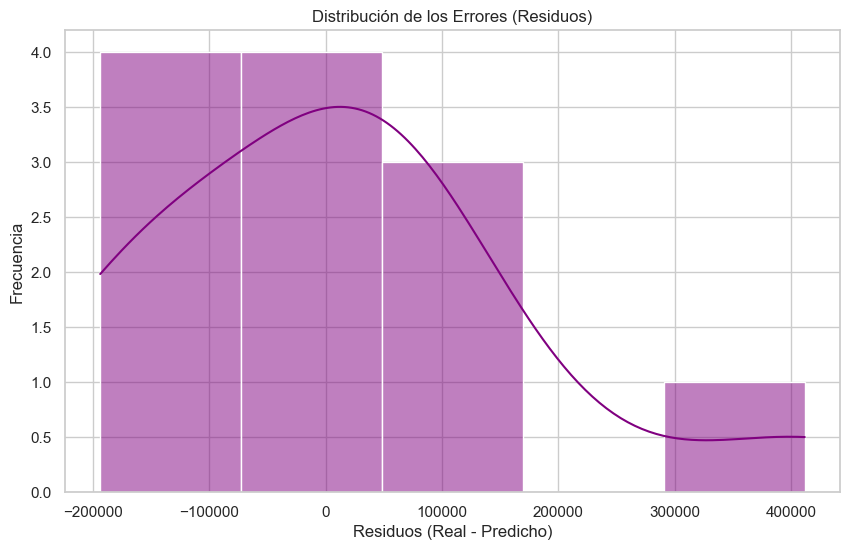

In [10]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.linear_model import LinearRegression
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Selección de Variables
features = ['m2', 'ambientes', 'baños', 'dormitorios', 'cocheras']
target = 'precio_usd'

X = df_clean[features]
y = df_clean[target]

# 2. División en Train y Test (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Datos de entrenamiento: {X_train.shape}")
print(f"Datos de prueba: {X_test.shape}")

# 3. Entrenamiento del Modelo
model = LinearRegression()
model.fit(X_train, y_train)

# 4. Evaluación
y_pred = model.predict(X_test)

r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

# 5. Resultados
print("\n--- Resultados del Modelo ---")
print(f"R² Score: {r2:.4f}")
print(f"MAE: USD {mae:,.2f}")
print(f"RMSE: USD {rmse:,.2f}")

# 6. Coeficientes
print("\n--- Coeficientes ---")
for feature, coef in zip(features, model.coef_):
    print(f"{feature}: {coef:,.2f}")
print(f"Intercepto: {model.intercept_:,.2f}")

# 7. Visualización
sns.set_style("whitegrid")

# Gráfico Real vs Predicho
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.5, color='blue')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Precio Real (USD)')
plt.ylabel('Precio Predicho (USD)')
plt.title('Regresión Lineal: Precio Real vs Predicho')
plt.show()

# Distribución de Residuos
residuals = y_test - y_pred
plt.figure(figsize=(10, 6))
sns.histplot(residuals, kde=True, color='purple')
plt.xlabel('Residuos (Real - Predicho)')
plt.ylabel('Frecuencia')
plt.title('Distribución de los Errores (Residuos)')
plt.show()